# Character Recognition with Semeion Dataset

### Imports

In [1]:
import os
import datetime
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework import dtypes, random_seed

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Helper libraries
import numpy as np
import pandas as pd
import collections
from random import shuffle
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-alpha0


___

### Read the semeion dataset

The semeion dataset consists of 1593 digits from 0 to 9 manuscripts, which were scanned in gray scale and adjusted in a rectangle of 16x16, totaling 256 pixels. Each line in the file consists of the value of 256 pixels (normalized between 0 and 1), followed by the number indication that the 256 pixels represent. This indication is made using 10 values. For example, an entry corresponding to the number 0 is indicated by [1000000000].

The dataset is the object that will contain the data, and it has three attributes: train, test and data. Since train corresponds to 80% of the data scrambled and test corresponds to 20% of the scrambled data, each containing the images and labels. But, the data attribute has all the dataset also separated between images and labels but sorted as it comes in the file.

In [2]:
class DataSet(object):
    def __init__(self, images, labels, reshape = False, seed = None):
        seed1, seed2 = random_seed.get_seed(seed)

        #If op level seed is not set, use whatever graph level seed is returned
        np.random.seed(seed1 if seed is None else seed2)

        assert images.shape[0] == labels.shape[0], ('images.shape: %s labels.shape: %s' % (images.shape, labels.shape))

        self.num_examples = images.shape[0]

        #Convert shape from [num examples, rows, columns, depth] to [num examples, rows*columns](assuming depth == 1)
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])

        self.images = images
        self.labels = labels
        


def read_data_semeion(fname = 'data/semeion.data', test_split=False):
    file = open(fname, 'r')
    lines = file.readlines()

    width = 16
    height = 16
    size = width * height
    classes = 10

    images = [];
    labels = [];
    fnumber = 0;

    for line in lines:
        data = line.split(' ')
        image = [];
        label = [];

        for i in range(0, size):
            image.append(int(float(data[i])))
        images.append(image)

        for i in range(size, size + classes):
            label.append(int(float(data[i]))) 
        labels.append(label)

        fnumber += 1
    

    Datasets = collections.namedtuple('Datasets', ['train', 'test', 'data'])
    
    #Shuffle data
    images_shuffle = []
    labels_shuffle = []
    indexes = list(range(len(images)))
    shuffle(indexes)
    for i in indexes:
        images_shuffle.append(images[i])
        labels_shuffle.append(labels[i])

    images = images_shuffle
    labels = labels_shuffle

    samples = len(lines)
    train_samples = int(0.8*samples)
    test_samples = int(0.2*samples) + 1

    #Train set
    image_train = np.array(images[:train_samples], dtype=np.uint8)
    image_train = image_train.reshape(train_samples, width, height)

    label_train = np.array(labels[:train_samples], dtype=np.uint8)

    train = DataSet(image_train, label_train, reshape=False)

    #test set
    image_test = np.array(images[train_samples:], dtype=np.uint8)
    image_test = image_test.reshape(test_samples, width, height)

    label_test = np.array(labels[train_samples:], dtype=np.uint8)

    test = DataSet(image_test, label_test, reshape=False)

    image_data = np.array(images, dtype=np.uint8)
    image_data = image_data.reshape(samples, width, height)
    data = DataSet(image_data, np.array(labels, dtype=np.uint8))

    return Datasets(train=train, test=test, data=data)


dataset = read_data_semeion()

#### Check the shape of the dataset

In [3]:
dataset.data.images.shape

(1593, 16, 16)

In [4]:
dataset.data.labels.shape

(1593, 10)

In [5]:
dataset.train.images.shape

(1274, 16, 16)

In [6]:
dataset.train.labels.shape

(1274, 10)

In [7]:
dataset.test.images.shape

(319, 16, 16)

In [8]:
dataset.test.labels.shape

(319, 10)

#### Plot some images

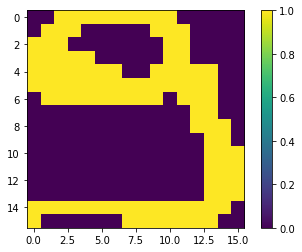

In [9]:
plt.figure()
plt.imshow(dataset.test.images[301])
plt.colorbar()
plt.grid(False)

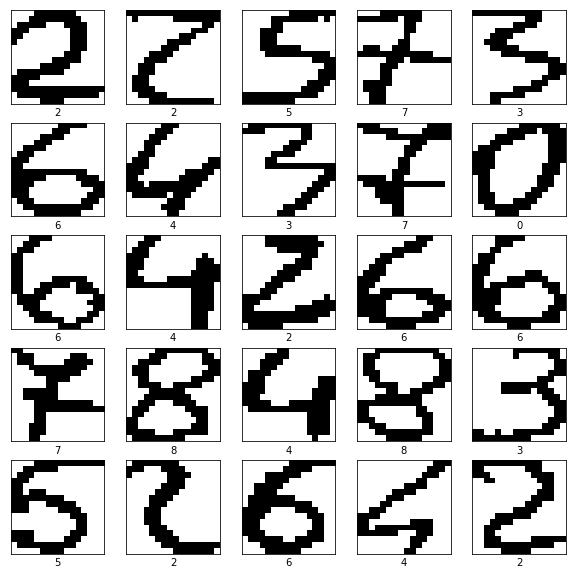

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset.data.images[i], cmap=plt.cm.binary)
    plt.xlabel(np.argmax(dataset.train.labels[i]))
plt.show()

___

### Create the first model architecture

The multi-layer perceptron depicted below has an input layer that simply transforms images from 16x16 to 256. It has a hidden layer with 64 neurons and an output layer with 10 neurons. The activation functions used were the logistic function (sigmoid).

In [11]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(16, 16)))
    model.add(keras.layers.Dense(64, activation='sigmoid'))
    model.add(keras.layers.Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=64, 
                                 verbose=0)

the scores assessed on this problem are accuracy, precision, recall and f1_score.

In [13]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='weighted'),
           'recall' : make_scorer(recall_score, average='weighted'), 
           'f1_score' : make_scorer(f1_score, average='weighted')}

The labels have returned to categorization where a one-hot-embedding is not used. That is, [0100000000] becomes 1.

In [14]:
Y = []
for y in range(len(dataset.data.labels)):
    Y.append(np.argmax(dataset.data.labels[y]))

Here the model is trained using cross-validation with five subsets with the same proportion of classes.

In [15]:
# Evaluate neural network using five-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_results = cross_validate(neural_network, dataset.data.images, Y, cv=kfold, scoring=scoring, return_train_score=False)

The results are:

In [16]:
acc_results

{'fit_time': array([8.20788121, 7.66481924, 7.51336789, 6.93043232, 7.25946999]),
 'score_time': array([0.04390812, 0.04188776, 0.0478971 , 0.04188824, 0.04890108]),
 'test_accuracy': array([0.94427245, 0.90625   , 0.93730408, 0.9148265 , 0.92038217]),
 'test_precision': array([0.94632749, 0.90877371, 0.93804929, 0.92000498, 0.92255684]),
 'test_recall': array([0.94427245, 0.90625   , 0.93730408, 0.9148265 , 0.92038217]),
 'test_f1_score': array([0.94445396, 0.906633  , 0.93694567, 0.91598158, 0.92021833])}

Transforming the results into a dataset to export to latex.

In [17]:
df = pd.DataFrame(acc_results)
df.drop(columns=['fit_time', 'score_time'], inplace=True)
columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df.columns = columns
df.head()

,Accuracy,Precision,Recall,F1-Score
0,0.944272,0.946327,0.944272,0.944454
1,0.906250,0.908774,0.906250,0.906633
2,0.937304,0.938049,0.937304,0.936946
3,0.914826,0.920005,0.914826,0.915982
4,0.920382,0.922557,0.920382,0.920218


___

### Analysis of results

In [18]:
val_predict = cross_val_predict(neural_network, dataset.data.images, Y, cv=kfold)
val_predict

array([2, 2, 5, ..., 2, 8, 5], dtype=int64)

Generating the normalized confusion matrix and a classification report

In [19]:
conf_mx = confusion_matrix(Y, val_predict)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

class_rep = classification_report(Y, val_predict)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       161
           1       0.89      0.91      0.90       162
           2       0.92      0.92      0.92       159
           3       0.92      0.92      0.92       159
           4       0.92      0.92      0.92       161
           5       0.95      0.93      0.94       159
           6       0.93      0.97      0.95       161
           7       0.93      0.91      0.92       158
           8       0.90      0.85      0.87       155
           9       0.87      0.91      0.89       158

   micro avg       0.92      0.92      0.92      1593
   macro avg       0.92      0.92      0.92      1593
weighted avg       0.92      0.92      0.92      1593



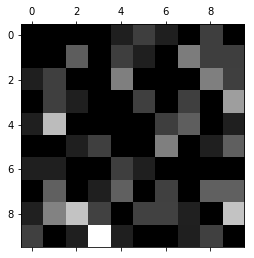

In [20]:
print(class_rep)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

____

### Saving the tensorflow model

To save the model in lite format of tensorflow it was necessary to fit the network again. After the adjustment, the model was saved in the format of the tensorflow lite to be read and performed the statistical inference on the client's cell phone.

In [24]:
model_save = create_model()
model_save.fit(dataset.data.images, dataset.data.labels, epochs=100, batch_size=64)

Epoch 1/100
1593/1593 [==============================] - 0s 147us/sample - loss: 2.1777 - accuracy: 0.3427
Epoch 2/100
1593/1593 [==============================] - 0s 73us/sample - loss: 1.9211 - accuracy: 0.7250
Epoch 3/100
1593/1593 [==============================] - 0s 74us/sample - loss: 1.6590 - accuracy: 0.7916
Epoch 4/100
1593/1593 [==============================] - 0s 83us/sample - loss: 1.4071 - accuracy: 0.8299
Epoch 5/100
1593/1593 [==============================] - 0s 70us/sample - loss: 1.1881 - accuracy: 0.8619
Epoch 6/100
1593/1593 [==============================] - 0s 64us/sample - loss: 1.0115 - accuracy: 0.8763
Epoch 7/100
1593/1593 [==============================] - 0s 66us/sample - loss: 0.8720 - accuracy: 0.8864
Epoch 8/100
1593/1593 [==============================] - 0s 61us/sample - loss: 0.7602 - accuracy: 0.8983
Epoch 9/100
1593/1593 [==============================] - 0s 63us/sample - loss: 0.6718 - accuracy: 0.9065
Epoch 10/100
1593/1593 [=====================

1593/1593 [==============================] - 0s 62us/sample - loss: 0.0294 - accuracy: 0.9994
Epoch 78/100
1593/1593 [==============================] - 0s 67us/sample - loss: 0.0286 - accuracy: 0.9994
Epoch 79/100
1593/1593 [==============================] - 0s 61us/sample - loss: 0.0278 - accuracy: 0.9994
Epoch 80/100
1593/1593 [==============================] - 0s 55us/sample - loss: 0.0270 - accuracy: 0.9994
Epoch 81/100
1593/1593 [==============================] - 0s 56us/sample - loss: 0.0263 - accuracy: 0.9994
Epoch 82/100
1593/1593 [==============================] - 0s 64us/sample - loss: 0.0256 - accuracy: 0.9994
Epoch 83/100
1593/1593 [==============================] - 0s 64us/sample - loss: 0.0250 - accuracy: 1.0000
Epoch 84/100
1593/1593 [==============================] - 0s 57us/sample - loss: 0.0243 - accuracy: 0.9994
Epoch 85/100
1593/1593 [==============================] - 0s 54us/sample - loss: 0.0236 - accuracy: 1.0000
Epoch 86/100
1593/1593 [==========================

In [29]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model_save(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model_save.inputs[0].shape, model_save.inputs[0].dtype))

# Convert the model.
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()

open("converted_model.tflite", "wb").write(tflite_model)